# Problem set 1 : Seeing in Color

#  PROBLEM 1 : color alignment

In [256]:
# setting up the environment

import numpy as np
import cv2  # if you don't have it, you can install it in anaconda prompt: pip install opencv-python
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy
import scipy.ndimage
from imageio import imread, imsave
%matplotlib inline

Below is the code for reading the individual channels of the images, that were provided in the starter notebook. Please keep scrolling to view all the images.

Image size: 370 x 370


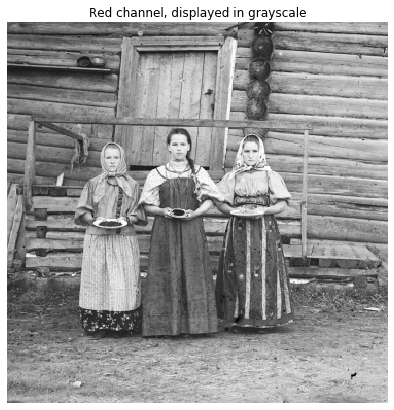

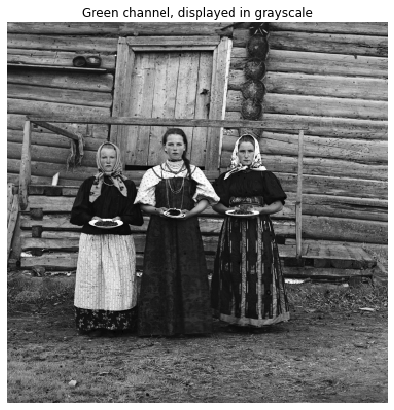

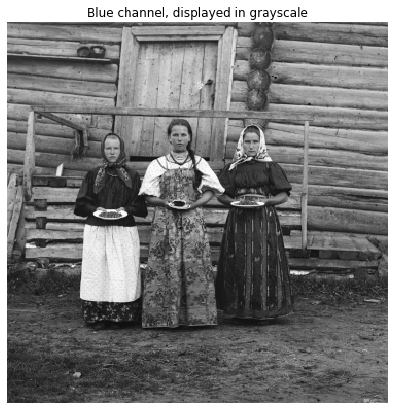

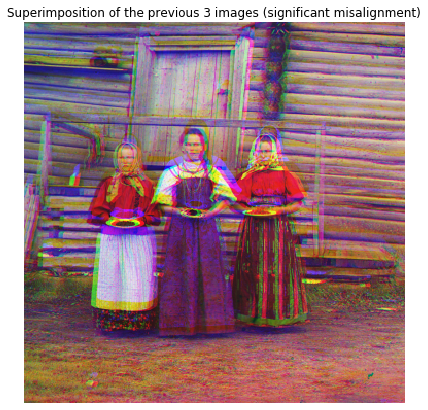

In [257]:
# reading the three color channels, and displaying them (as way as the default alignment)
red = np.array(imread('images/prokudin-girls-red.ppm', as_gray=True)/255.0)
blue = np.array(imread('images/prokudin-girls-blue.ppm', as_gray=True)/255.0)
green = np.array(imread('images/prokudin-girls-green.ppm', as_gray=True)/255.0)

print('Image size: %d x %d'% (blue.shape[0],blue.shape[1]))

# right figure size will make sure the images are displayed well, without too much aliasing or blur
plt.figure(figsize=(14,7))
plt.axis('off')
plt.title("Red channel, displayed in grayscale")
plt.imshow(red, cmap='gray')

plt.figure(figsize=(14,7))
plt.axis('off')
plt.title("Green channel, displayed in grayscale")
plt.imshow(green, cmap='gray')

plt.figure(figsize=(14,7))
plt.axis('off')
plt.title("Blue channel, displayed in grayscale")
plt.imshow(blue, cmap='gray')

# now try to just superimpose the three channels; you will see significant color artifacts due to misalignment
color=np.dstack((red,green,blue))
plt.figure(figsize=(14,7))
plt.axis('off')
plt.title("Superimposition of the previous 3 images (significant misalignment)")
plt.imshow(color)

Now go ahead: implement the code for searching for the optimal alignment, and test it first on the test_image where you can introduce "synthetic" shifts, and make sure you recover from them; and then the Prokudin-Gorskii image we used above, as well as the other triplet provided (the rock image), and any additonal triplets if you would like.

## 1.1 Synthetic (”manufactured”) offsets

Notice that in equation (1) of the question paper, the estimated values of $(t_R, t_B)$ are given by:

$$(t^*_R, t^*_B)\ =\ argmin_{t_R, t_B\in \mathrm{T}} \left[D(t_R(R),G) + D(t_B(B),G)\right]$$
Note, however, that this $argmin$ decouples over $t_R$ and $t_B$ since neither of the summands depend simultaneously on both $t_R$ and $t_B$. In other words, for any transformation $t_B$, $t^*_R$ depends entirely on $D(t_R(R),G)$, and vice versa.

Thus, we get that
$$t^*_R\ =\ argmin_{t_R\in\mathrm{T}} D(t_R(R),G)$$
$$t^*_B\ =\ argmin_{t_B\in \mathrm{T}} D(t_B(B),G)$$

This helps in decreasing the number of for loops required for the exhaustive search, and makes our code run faster.

### 1.1.1 Naive stacking

Below, we implement naive stacking, where we simply superimpose the randomly horizontally $+$ vertically shifted color channels. Padding has also been done using `numpy.roll`.

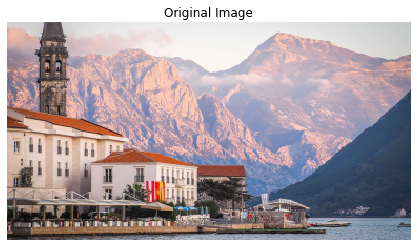

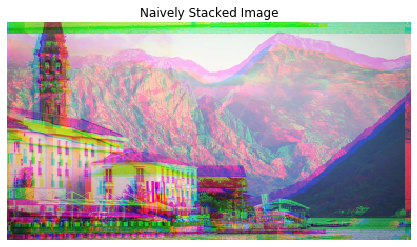

In [262]:
timage = np.array(imread('images/test-image.png')/255.0)

timage_red = timage[:,:,0]
timage_green = timage[:,:,1]
timage_blue = timage[:,:,2]

# Horizontal shift for Red channel
timage_red_shift = np.roll(timage_red, np.rint(np.random.uniform(-15,15)).astype(int), axis=1)
# Vertical shift for Red channel
timage_red_shift = np.roll(timage_red_shift, np.rint(np.random.uniform(-15,15)).astype(int), axis=0)

# Horizontal shift for Blue channel
timage_blue_shift = np.roll(timage_blue, np.rint(np.random.uniform(-15,15)).astype(int), axis=1)
# Vertical shift for Blue channel
timage_blue_shift = np.roll(timage_blue_shift, np.rint(np.random.uniform(-15,15)).astype(int), axis=0)

# Displaying original image
plt.figure(figsize=(8,4))
plt.axis('off')
plt.title("Original Image")
plt.imshow(timage)

# Displaying naively stacked image
timage_color = np.dstack((timage_red_shift, timage_green, timage_blue_shift))
plt.figure(figsize=(8,4))
plt.axis('off')
plt.title("Naively Stacked Image")
plt.imshow(timage_color)

### 1.1.2 Alignment with SSD

As proven above, equation $(1)$ given in the question paper, decouples with respect to $t_R$ and $t_B$. Hence instead of running 4 nested `for` loops, we simply need to 2 different `for` loops over the cartesian product of horizontal and vertical translations in the $\pm 15$ pixel window, and store the measures of SSD for every pair of horizontal and vertical translations, for both the red as well as blue channels. The discrepancy measure is taken to be SSD below. 

In [263]:
def SSD(u, v):
    return np.sum((u-v)**2)

ssd_red = np.empty([31,31])
ssd_blue = np.empty([31,31])

x = range(31)
y = range(31)

for h_red, v_red in np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))]):
    test_red = np.roll(timage_red_shift, v_red-15, axis=0)
    test_red = np.roll(test_red, h_red-15, axis=1)
    
    ssd_red[h_red, v_red] = SSD(test_red, timage_green)
    

for h_blue, v_blue in np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))]):
    test_blue = np.roll(timage_blue_shift, v_blue-15, axis=0)
    test_blue = np.roll(test_blue, h_blue-15, axis=1)
    
    ssd_blue[h_blue, v_blue] = SSD(test_blue, timage_green)

We have taken `argmin()` over the arrays of SSD measures, because we want the least discrepancy between the original and the reconstructed image.

In [264]:
red_transform = np.asarray(np.unravel_index(ssd_red.argmin(), ssd_red.shape)) - np.array([15, 15])
blue_transform = np.asarray(np.unravel_index(ssd_blue.argmin(), ssd_blue.shape)) - np.array([15, 15])

print(red_transform)
print(blue_transform)

[  6 -11]
[ -2 -11]


We now reconstruct the image using the alignment that minimizes the SSD discrepancy.

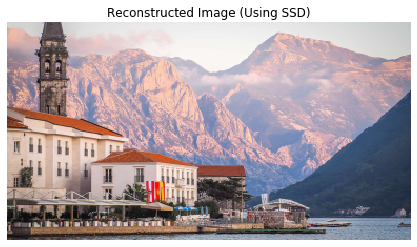

In [265]:
timage_red_reconstruct = np.roll(timage_red_shift, red_transform[1], axis=0)
timage_red_reconstruct = np.roll(timage_red_reconstruct, red_transform[0], axis=1)

timage_blue_reconstruct = np.roll(timage_blue_shift, blue_transform[1], axis=0)
timage_blue_reconstruct = np.roll(timage_blue_reconstruct, blue_transform[0], axis=1)

# Displaying reconstructed image (Using SSD)
timage_color_reconstruct = np.dstack((timage_red_reconstruct, timage_green, timage_blue_reconstruct))
plt.figure(figsize=(8,4))
plt.axis('off')
plt.title("Reconstructed Image (Using SSD)")
plt.imshow(timage_color_reconstruct)

### 1.1.3 Alignment with NCC

We use the same code as above, but just change `argmin` to `argmax`, since NCC is a measure of similarity.

In [266]:
def NCC(u, v):
    return np.sum(np.multiply(u, v))/(np.linalg.norm(u)*np.linalg.norm(v))

ncc_red = np.empty([31,31])
ncc_blue = np.empty([31,31])

x = range(31)
y = range(31)

for h_red, v_red in np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))]):
    test_red = np.roll(timage_red_shift, v_red-15, axis=0)
    test_red = np.roll(test_red, h_red-15, axis=1)
    
    ncc_red[h_red, v_red] = NCC(test_red, timage_green)
    

for h_blue, v_blue in np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))]):
    test_blue = np.roll(timage_blue_shift, v_blue-15, axis=0)
    test_blue = np.roll(test_blue, h_blue-15, axis=1)
    
    ncc_blue[h_blue, v_blue] = NCC(test_blue, timage_green)

We have taken `argmax()` below, because we want the highest similarity between the original and the reconstructed image.

In [267]:
red_transform = np.asarray(np.unravel_index(ncc_red.argmax(), ssd_red.shape)) - np.array([15, 15])
blue_transform = np.asarray(np.unravel_index(ncc_blue.argmax(), ssd_blue.shape)) - np.array([15, 15])

print(red_transform)
print(blue_transform)

[  6 -11]
[ -2 -11]


We now reconstruct the image using the alignment that maximizes the NCC similarity.

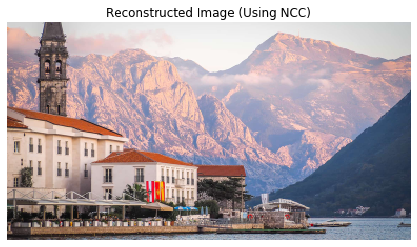

In [268]:
timage_red_reconstruct = np.roll(timage_red_shift, red_transform[1], axis=0)
timage_red_reconstruct = np.roll(timage_red_reconstruct, red_transform[0], axis=1)

timage_blue_reconstruct = np.roll(timage_blue_shift, blue_transform[1], axis=0)
timage_blue_reconstruct = np.roll(timage_blue_reconstruct, blue_transform[0], axis=1)

# Displaying reconstructed image (Using NCC)
timage_color_reconstruct = np.dstack((timage_red_reconstruct, timage_green, timage_blue_reconstruct))
plt.figure(figsize=(8,4))
plt.axis('off')
plt.title("Reconstructed Image (Using NCC)")
plt.imshow(timage_color_reconstruct)

A good method to qualtitatively evaluate the results for the test image is to calculate the sum of SSD's of the corresponding channels of the original image, and the reconstructed images. The smaller the SSD, the more accurate the reconstruction is. Similarly, instead of SSD, we could also use NCC, i.e. sum of NCC's of the corresponding channels of the original image, and the reconstructed images. The higher the NCC, the more accurate our reconstruction is. I am omitting the code, since we have simply been asked to discuss evaluation methods.

## 1.2 Real data

We now use SSD measure to reconstruct the image Prokudin girls, by aligning the color channels properly.

In [199]:
ssd_red = np.empty([31,31])
ssd_blue = np.empty([31,31])

x = range(31)
y = range(31)

for h_red, v_red in np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))]):
    test_red = np.roll(red, v_red-15, axis=0)
    test_red = np.roll(test_red, h_red-15, axis=1)
    
    ssd_red[h_red, v_red] = SSD(test_red, green)
    

for h_blue, v_blue in np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))]):
    test_blue = np.roll(blue, v_blue-15, axis=0)
    test_blue = np.roll(test_blue, h_blue-15, axis=1)
    
    ssd_blue[h_blue, v_blue] = SSD(test_blue, green)

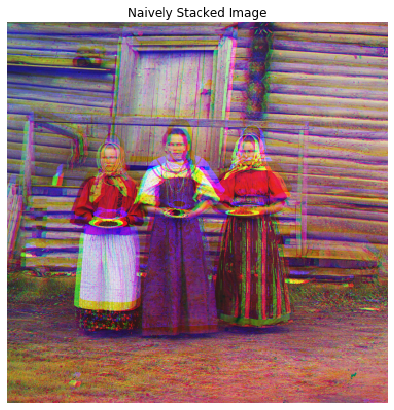

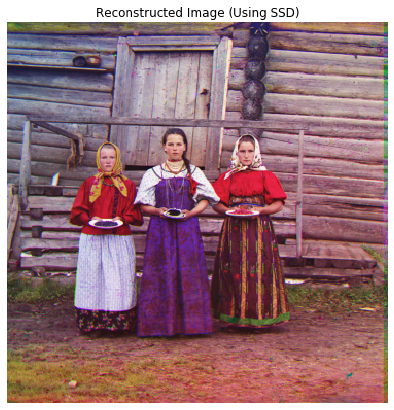

In [200]:
red_transform = np.asarray(np.unravel_index(ssd_red.argmin(), ssd_red.shape)) - np.array([15, 15])
blue_transform = np.asarray(np.unravel_index(ssd_blue.argmin(), ssd_blue.shape)) - np.array([15, 15])

red_reconstruct = np.roll(red, red_transform[1], axis=0)
red_reconstruct = np.roll(red_reconstruct, red_transform[0], axis=1)

blue_reconstruct = np.roll(blue, blue_transform[1], axis=0)
blue_reconstruct = np.roll(blue_reconstruct, blue_transform[0], axis=1)

# Displaying original image
plt.figure(figsize=(14,7))
plt.axis('off')
plt.title("Naively Stacked Image")
plt.imshow(color)

# Displaying reconstructed image (Using SSD)
color_reconstruct = np.dstack((red_reconstruct, green, blue_reconstruct))
plt.figure(figsize=(14,7))
plt.axis('off')
plt.title("Reconstructed Image (Using SSD)")
plt.imshow(color_reconstruct)

We now use the SSD measure to reconstruct the Prokudin rock image.

In [201]:
# reading the three color channels, and displaying them (as way as the default alignment)
rock_red = np.array(imread('images/prokudin-rock-red.ppm', as_gray=True)/255.0)
rock_blue = np.array(imread('images/prokudin-rock-blue.ppm', as_gray=True)/255.0)
rock_green = np.array(imread('images/prokudin-rock-green.ppm', as_gray=True)/255.0)

print(rock_red.shape)

(390, 425)


In [202]:
ssd_red = np.empty([31,31])
ssd_blue = np.empty([31,31])

x = range(31)
y = range(31)

for h_red, v_red in np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))]):
    test_red = np.roll(rock_red, v_red-15, axis=0)
    test_red = np.roll(test_red, h_red-15, axis=1)
    
    ssd_red[h_red, v_red] = SSD(test_red, rock_green)
    

for h_blue, v_blue in np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))]):
    test_blue = np.roll(rock_blue, v_blue-15, axis=0)
    test_blue = np.roll(test_blue, h_blue-15, axis=1)
    
    ssd_blue[h_blue, v_blue] = SSD(test_blue, rock_green)

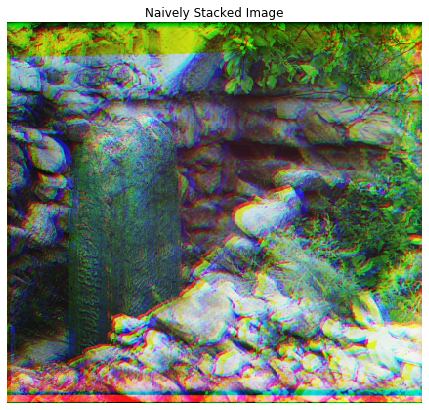

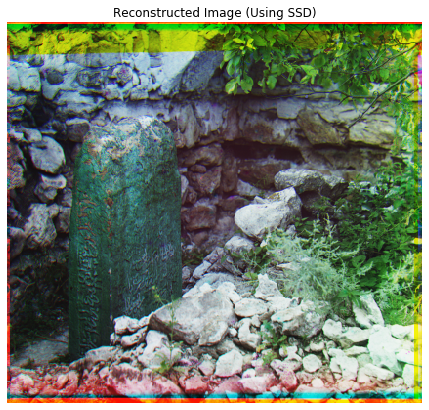

In [204]:
red_transform = np.asarray(np.unravel_index(ssd_red.argmin(), ssd_red.shape)) - np.array([15, 15])
blue_transform = np.asarray(np.unravel_index(ssd_blue.argmin(), ssd_blue.shape)) - np.array([15, 15])

rock_red_reconstruct = np.roll(rock_red, red_transform[1], axis=0)
rock_red_reconstruct = np.roll(rock_red_reconstruct, red_transform[0], axis=1)

rock_blue_reconstruct = np.roll(rock_blue, blue_transform[1], axis=0)
rock_blue_reconstruct = np.roll(rock_blue_reconstruct, blue_transform[0], axis=1)

# Displaying original image
rock_color = np.dstack((rock_red, rock_green, rock_blue))
plt.figure(figsize=(14,7))
plt.axis('off')
plt.title("Naively Stacked Image")
plt.imshow(rock_color)

# Displaying reconstructed image (Using SSD)
rock_color_reconstruct = np.dstack((rock_red_reconstruct, rock_green, rock_blue_reconstruct))
plt.figure(figsize=(14,7))
plt.axis('off')
plt.title("Reconstructed Image (Using SSD)")
plt.imshow(rock_color_reconstruct)

### 1.2.1 Bonus

In this subsection, I will use the SSD measure of discrepancy to align the color channels of a triptych from the Produkin-Gorskii collection. The picture I have chosen, is "Shkola v s. Pid ma imeni Ego Imperatorskago Vysochestva Gosudari a Nasli e dnika T S esarevicha Velikago Kni a zi a Aleksi e i a Nikolaevicha", which in English, translates to "School in the village of Pidma named after His Imperial Majesty, Sovereign, Heir Apparent, Crown Prince, Grand Duke Aleksei Nikolaevich".

I downloaded the triptych as a TIFF image (combined size of all 3 channels = 33.3 MB). I manually cropped the images using IrfanView, and since the images were huge, I resized them to $500\times 500$ pixels. Notice that since, the picture of the blue channel seemed to have been zoomed in a little bit, hence I also made sure to zoom in a bit before resizing to $500\times 500$. 

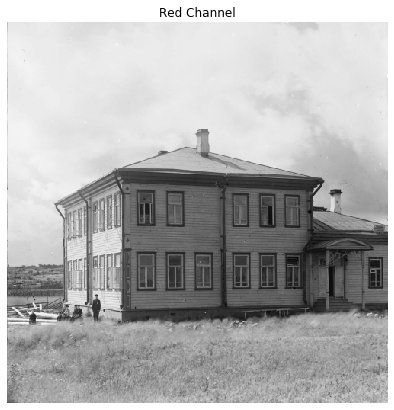

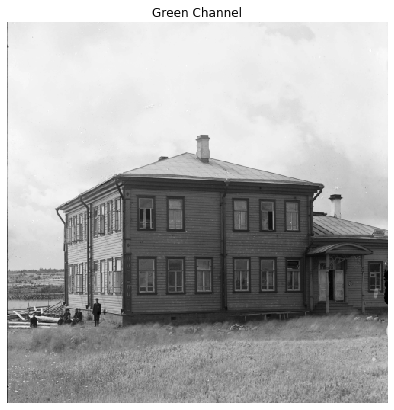

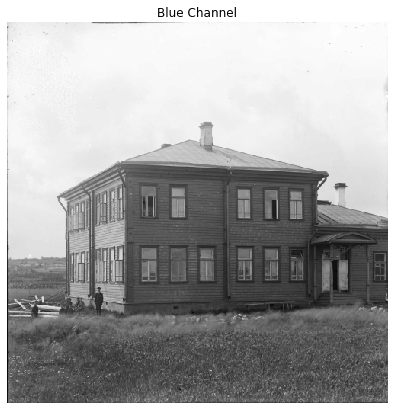

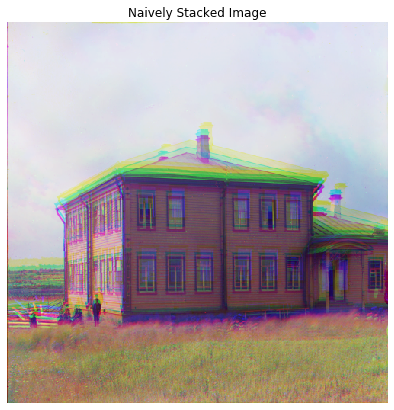

In [243]:
new_red = np.array(imread('images/new-red.jpg', as_gray=True)/255.0)
new_green = np.array(imread('images/new-green.jpg', as_gray=True)/255.0)
new_blue = np.array(imread('images/new-blue.jpg', as_gray=True)/255.0)

new_red = cv2.resize(new_red[100:-100, :], (500, 500), interpolation = cv2.INTER_AREA)
new_green = cv2.resize(new_green[100:-100, :], (500, 500), interpolation = cv2.INTER_AREA)
new_blue = cv2.resize(new_blue, (500, 500), interpolation = cv2.INTER_AREA)

plt.figure(figsize=(14,7))
plt.axis('off')
plt.title("Red Channel")
plt.imshow(new_red, cmap = 'gray')

plt.figure(figsize=(14,7))
plt.axis('off')
plt.title("Green Channel")
plt.imshow(new_green, cmap = 'gray')

plt.figure(figsize=(14,7))
plt.axis('off')
plt.title("Blue Channel")
plt.imshow(new_blue, cmap = 'gray')

new_color_reconstruct = np.dstack((new_red, new_green, new_blue))
plt.figure(figsize=(14,7))
plt.axis('off')
plt.title("Naively Stacked Image")
plt.imshow(new_color_reconstruct, cmap = 'gray')

Now I use the SSD method of alignment to obtain the reconstructed image. Since the channels are $500 \times 500$, I used a larger window of transformations, i.e. $\pm 30$ pixels.

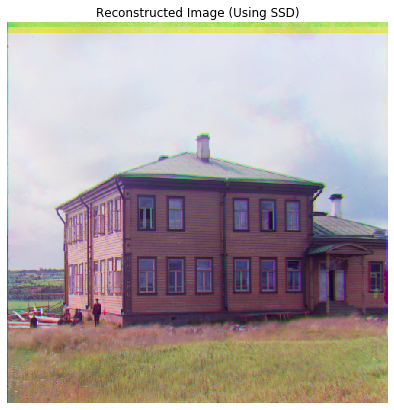

In [245]:
ssd_red = np.empty([61,61])
ssd_blue = np.empty([61,61])

x = range(61)
y = range(61)

for h_red, v_red in np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))]):
    test_red = np.roll(new_red, v_red-30, axis=0)
    test_red = np.roll(test_red, h_red-30, axis=1)
    
    ssd_red[h_red, v_red] = SSD(test_red, new_green)
    

for h_blue, v_blue in np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))]):
    test_blue = np.roll(new_blue, v_blue-30, axis=0)
    test_blue = np.roll(test_blue, h_blue-30, axis=1)
    
    ssd_blue[h_blue, v_blue] = SSD(test_blue, new_green)
    

red_transform = np.asarray(np.unravel_index(ssd_red.argmin(), ssd_red.shape)) - np.array([30, 30])
blue_transform = np.asarray(np.unravel_index(ssd_blue.argmin(), ssd_blue.shape)) - np.array([30, 30])

new_red_reconstruct = np.roll(new_red, red_transform[1], axis=0)
new_red_reconstruct = np.roll(new_red_reconstruct, red_transform[0], axis=1)

new_blue_reconstruct = np.roll(new_blue, blue_transform[1], axis=0)
new_blue_reconstruct = np.roll(new_blue_reconstruct, blue_transform[0], axis=1)

# Displaying reconstructed image (Using SSD)
new_color_reconstruct = np.dstack((new_red_reconstruct, new_green, new_blue_reconstruct))
plt.figure(figsize=(14,7))
plt.axis('off')
plt.title("Reconstructed Image (Using SSD)")
plt.imshow(new_color_reconstruct)

We can see that we have obtained a reasonably good reconstruction of the image (apart from the top part of the image, which has not been aligned well due to the padding). The url https://www.loc.gov/pictures/resource/ppem.01648/?co=prok serves as a good comparison, and I believe my reconstruction is decent enough.

# PROBLEM 2: Demosaicing Bayer patterns

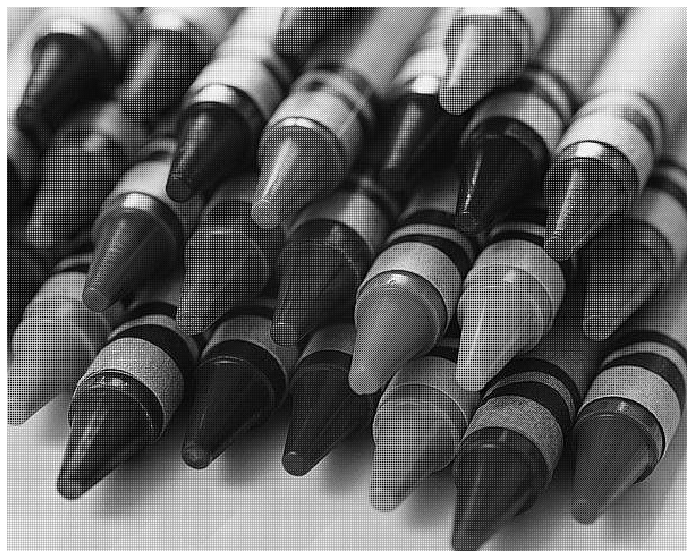

In [205]:
# we will work with this images, saved as a mosaic
# look at it first
image_path = 'images/crayons.bmp'

def read_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return image/255.0

mosaic_img = read_image(image_path)

# Visualize the mosaic; you will notice the "checkerboard" pattern 
# (you may need to make the figure larger or smaller to see it clearly)
plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(mosaic_img, cmap='gray')

## 2.1 Naive demosaicing (Linear Interpolation)

Each color channel has been separately interpolated below. Instead of using `for` loops, we have used filters, i.e. convolutions. For red and blue channels, based on the hint, I used the following kernel:
$$\frac{1}{4}\begin{bmatrix}
1 & 2 & 1\\
2 & 4 & 2\\
1 & 2 & 1
\end{bmatrix}$$
and for the green channel, this was the kernel used:
$$\frac{1}{4}\begin{bmatrix}
0 & 1 & 0\\
1 & 4 & 1\\
0 & 1 & 0
\end{bmatrix}$$

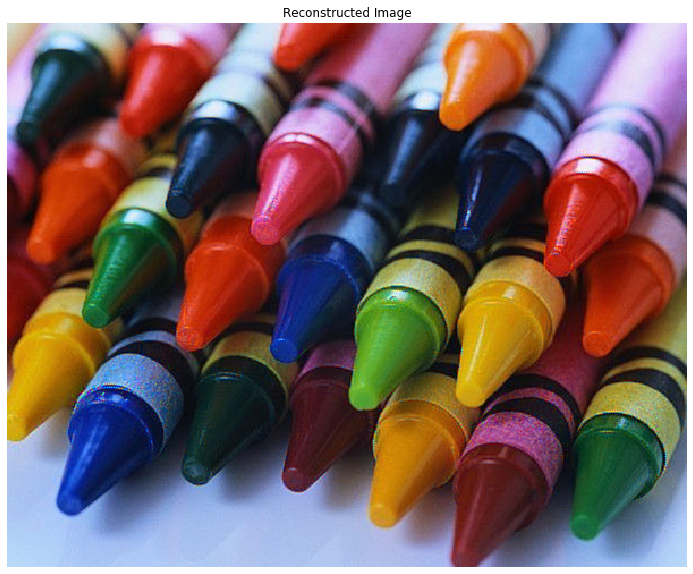

In [246]:
h, w = mosaic_img.shape

r = np.zeros_like(mosaic_img)
r[0:h:2, 0:w:2] = mosaic_img[0:h:2, 0:w:2]

b = np.zeros_like(mosaic_img)
b[1:h:2, 1:w:2] = mosaic_img[1:h:2, 1:w:2]

g = mosaic_img - r - b

def interp_rb(src):
    kernel = np.array([1,2,1,2,4,2,1,2,1], dtype = np.float32).reshape([3,3])/4.0
    return cv2.filter2D(src, -1, kernel)

def interp_gr(src):
    kernel = np.array([0,1,0,1,4,1,0,1,0], dtype = np.float32).reshape([3,3])/4.0
    return cv2.filter2D(src, -1, kernel)

r_img = interp_rb(r)
b_img = interp_rb(b)
g_img = interp_gr(g)

recons_img = np.dstack((r_img, g_img, b_img))
plt.figure(figsize=(20,10))
plt.axis('off')
plt.title("Reconstructed Image")
plt.imshow(recons_img)

As mentioned in the the question paper, little color splotches/speckles that clearly are a result of noisy interpolation, are visible in various parts of the image when zoomed, especially on the wrapper of the lower-left-most blue crayon, and the shiny surface of the upper-rightmost red crayon.

## 2.2 Freeman's Method

Tie the R and B channels to G, as described; take care to scale the color values (and then un-scale them) to make sure they have the same mean across channels. I have chosen median filters of 4 different sizes: 3, 7, 11, and 45, to see which one of them gives a good image.

In [247]:
r_mean, g_mean, b_mean = r_img.mean(), g_img.mean(), b_img.mean()
r_img_wmean = r_img - r_mean
g_img_wmean = g_img - g_mean
b_img_wmean = b_img - b_mean

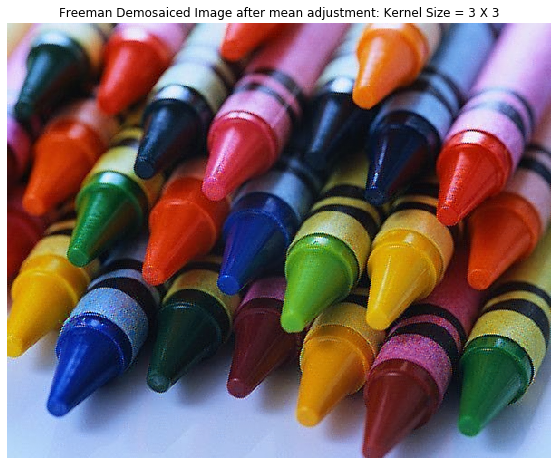

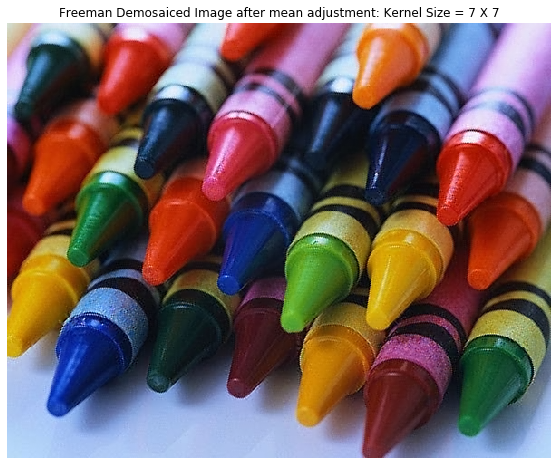

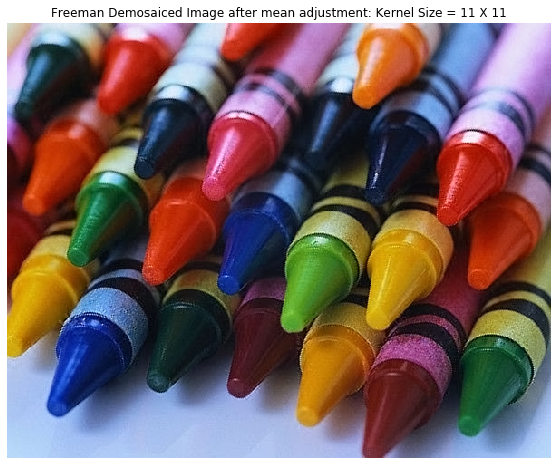

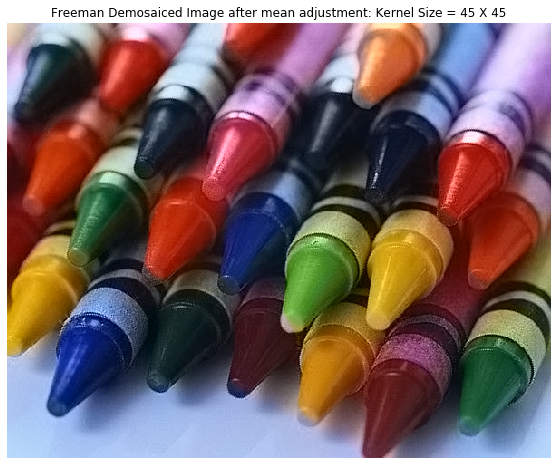

In [248]:
mf_sizes = [3, 7, 11, 45]

for mf_size in mf_sizes:    
    r_g_wmean = scipy.ndimage.median_filter(r_img_wmean - g_img_wmean, size = mf_size)
    b_g_wmean = scipy.ndimage.median_filter(b_img_wmean - g_img_wmean, size = mf_size)

    color2 = np.clip(np.dstack((r_g_wmean + r_mean + g_img_wmean, g_img, b_g_wmean + b_mean + g_img_wmean)), 0.0, 1.0)
    plt.figure(figsize=(10, 8))
    plt.axis('off')
    plt.title("Freeman Demosaiced Image after mean adjustment: Kernel Size = %d X %d" % (mf_size, mf_size))
    plt.imshow(color2)

To analyze the above reconstructions, let us first look at the extremes: kernel sizes of 3 and 45. 

$\bullet\ $ For a $3\times 3$ median filter, the reconstructed image is very similar to the naively interpolated image, i.e. it has small (albeit less than the interpolated one) splotches of color on the crayons. The wrapper of the lower-left-most blue crayon, and the shiny surface of the upper-rightmost red crayon are good references and small multicolored pixels are visible upon zooming.

$\bullet\ $ For a $45\times 45$ median filter, while "fine" noise in the image seem to be absent, the edges of crayons in the reconstructed image seem to be getting too blurry. The most jarring are the tips of the crayons, where it is clearly visible that relatively large areas have been filled with colors belonging to other crayons.

Thus, too small a filter does not get rid of the fine interpolation noise, while too large a filter introduces new issues like relatively large chunks of other color near the edges of the crayons. Thus, an intermediate size of filter, for example, $11\times 11$, seem to be best as it makes the image reasonably smooth, and does not introduce new splotches.